# PEM Injection 解析 (Coupling Function Analysis) チュートリアル

このノートブックでは `gwexpy` の `CouplingFunctionAnalysis` を使用して、物理環境モニタリング (PEM) インジェクション試験の解析を行う方法を示します。

## 目的
PEM インジェクション試験では、センサー（Witness）から干渉計（Target）への物理的なノイズ結合関数（Coupling Function, CF）を推定します。
CF は以下の式で定義されます：
$$CF(f) = \sqrt{\frac{P_{\text{target, inj}}(f) - P_{\text{target, bkg}}(f)}{P_{\text{witness, inj}}(f) - P_{\text{witness, bkg}}(f)}}$$
$$ \sqrt{P}_{\text{target, projection}}(f) = CF(f) \cdot \sqrt{P}_{\text{witness, bkg}}(f)$$
ここで $P$ は各状態におけるパワースペクトル密度 (PSD) です。

Injection による有意な超過が Target チャンネルで見られない場合は、上限値を与えます。
$$CF_{\text{UL}}(f) = \sqrt{\frac{P_{\text{target, threshold}}(f) - P_{\text{target, bkg}}(f)}{P_{\text{witness, inj}}(f) - P_{\text{witness, bkg}}(f)}}$$
$$ \sqrt{P}_{\text{target, UL}}(f) = CF_{\text{UL}}(f) \cdot \sqrt{P}_{\text{witness, bkg}}(f)$$

この解析により、環境ノイズがどの程度主信号に影響を与えるかを定量化し、ノイズバジェットの策定に役立てることができます。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from gwpy.timeseries import TimeSeries, TimeSeriesDict
from gwexpy.analysis import estimate_coupling, SigmaThreshold, PercentileThreshold

# グラフのスタイル設定
plt.rcParams["figure.figsize"] = (10, 6)

## 1. 擬似データの生成

バックグラウンド状態と、特定の周波数帯でノイズを注入したインジェクション状態のデータをシミュレーションします。

- **Witness**: センサー（例：マイク、加速度計）
- **Target**: 干渉計メイン信号（例：DARM）
- **Coupling**: Witness から Target への結合（ここでは $CF = 0.1$ の定数結合を想定）

In [2]:
fs = 2048  # サンプリング周波数 [Hz]
duration = 32  # 期間 [s]
t = np.linspace(0, duration, duration * fs, endpoint=False)
cf_true = 2e-22

def create_pem_data(is_injection=False):
    # 1. Witness Data (White noise)
    wit_noise = np.random.normal(0, 1.0, len(t))
    if is_injection:
        # ブロードなノイズを注入
        wit_noise += np.random.normal(0, 5.0, len(t))

    # 2. Target Data (Independent noise: Shaped + Coupled noise)
    # 1e-24 オーダーで、100Hz 付近が最小になるような下に凸なスペクトル
    freqs = np.fft.rfftfreq(len(t), d=1/fs)
    # ASD 形状: 1e-24 * sqrt((f/100)**-6 + (f/100)**4 + 1)
    # f=0 での発散を避けるため微小値を足す
    f_norm = (freqs + 0.1) / 100.0
    asd_shape = 1e-24 * np.sqrt(f_norm**-6 + f_norm**4 + 1.0)

    # 周波数ドメインでノイズ生成
    n = len(t)
    # 複素標準正規分布ノイズ
    white_noise_f = (np.random.normal(size=len(freqs)) + 1j * np.random.normal(size=len(freqs))) / np.sqrt(2)
    # ASDを掛けて、スケーリング (sqrt(fs * n / 2) は振幅スペクトル密度の定義に基づく)
    tgt_noise_f = white_noise_f * asd_shape * np.sqrt(fs * n / 2)
    tgt_noise = np.fft.irfft(tgt_noise_f, n=n)

    # Coupled noise: Witness * CF
    # CF を 2e-23 程度にして、バックグラウンドに対して優位または同程度にする
    tgt_noise += wit_noise * cf_true

    # Create TimeSeries
    wit = TimeSeries(wit_noise, t0=0, sample_rate=fs, unit=u.V, name="PEM:WITNESS")
    tgt = TimeSeries(tgt_noise, t0=0, sample_rate=fs, unit=u.m, name="GW:TARGET")

    return TimeSeriesDict({"PEM:WITNESS": wit, "GW:TARGET": tgt})
# データ生成
data_bkg = create_pem_data(is_injection=False)
data_inj = create_pem_data(is_injection=True)

print("Data generated successfully.")

Data generated successfully.


## 2. 結合関数の推定 (基本)

`estimate_coupling` 関数を使用して、インジェクションデータとバックグラウンドデータから結合関数を計算します。
デフォルトでは `RatioThreshold()` が使用され、バックグラウンドに対して Witness の PSD が 25倍以上、Target の PSD が 4倍以上の場所のみを有効なデータとして扱います。

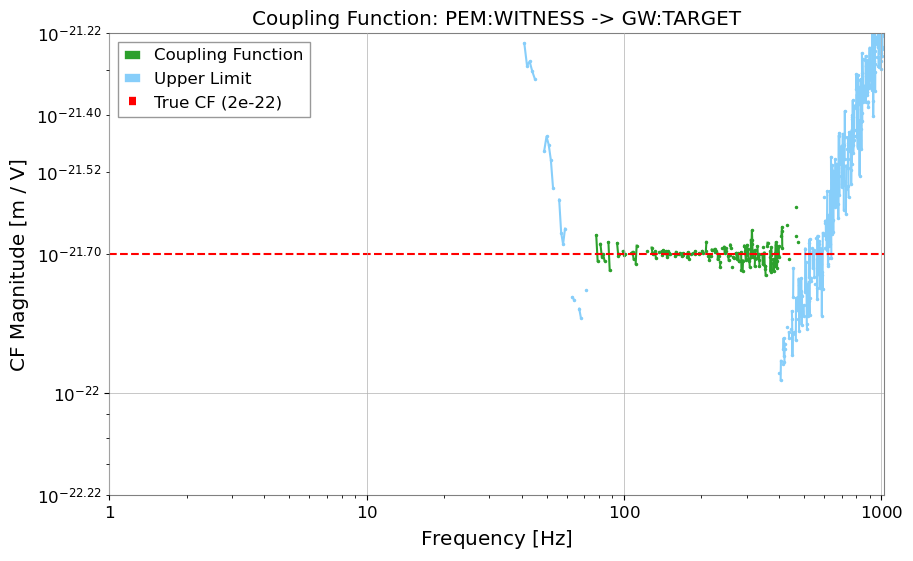

In [3]:
# 結合関数の推定
# fftlength=1.0s (1Hz resolution)
result = estimate_coupling(
    data_inj,
    data_bkg,
    fftlength=1.0,
    witness="PEM:WITNESS"
)

# 推定された CF のプロット
result.plot_cf()
plt.axhline(cf_true, color="red", linestyle="--", label=f"True CF ({cf_true})")
plt.ylim(0.3*cf_true, 3*cf_true)
plt.legend()

## 3. 診断プロット

`plot()` メソッドを使用すると、Witness の PSD、Target の PSD、および結果の CF を一度に確認できます。
インジェクションによってどの程度 PSD が上昇したか（しきい値を超えたか）を視覚的に確認するのに便利です。

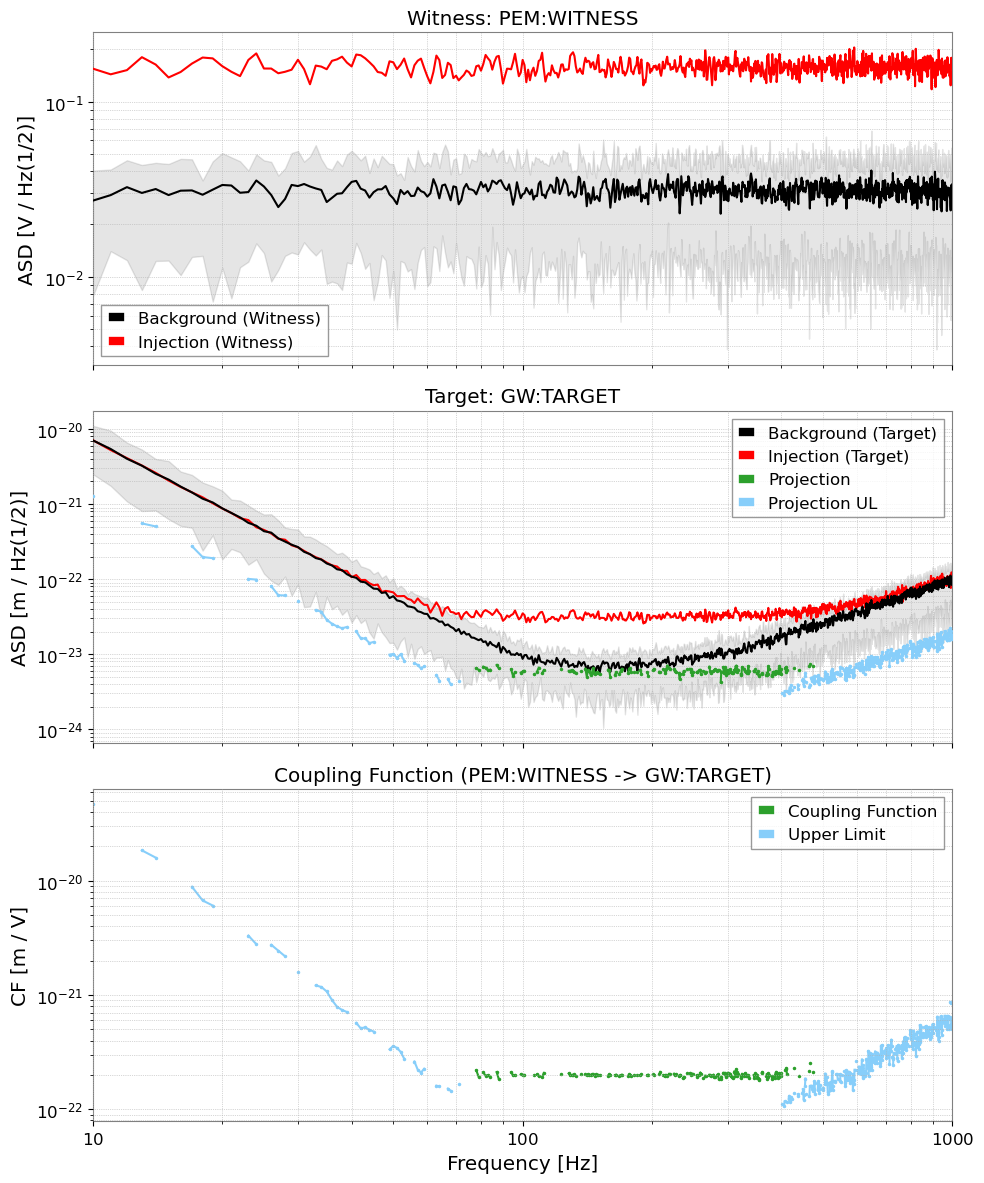

In [4]:
result.plot(xlim=(10, 1000))
plt.show()

## 4. 高度なしきい値戦略

`gwexpy` では、インジェクションを検出するための戦略を柔軟に変更できます。

### SigmaThreshold
統計的な有意性（Gaussian noise を仮定）に基づき、「平均 + N * 標準誤差」を越えるものを検出します。

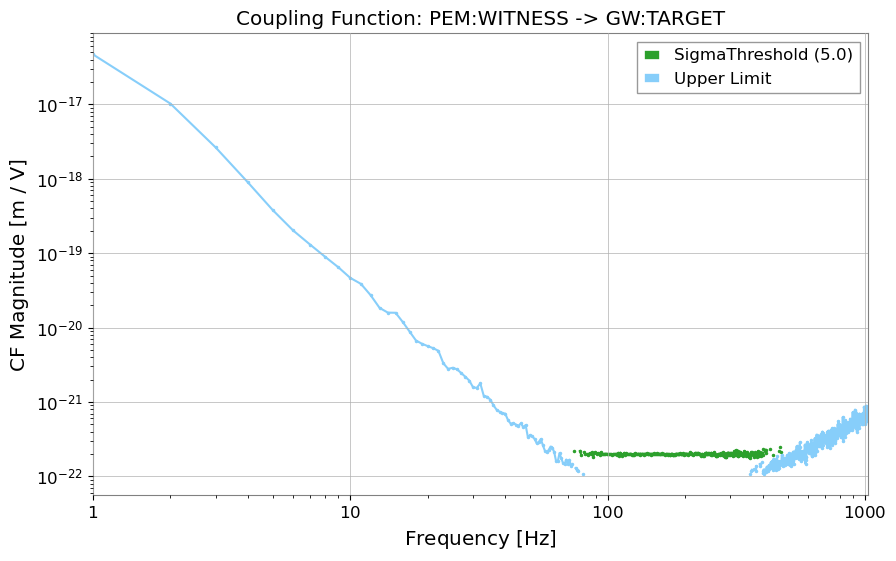

In [5]:
strategy_sigma = SigmaThreshold(sigma=5.0)

result_sigma = estimate_coupling(
    data_inj, data_bkg,
    fftlength=1.0,
    threshold_witness=strategy_sigma
)

result_sigma.plot_cf(label="SigmaThreshold (5.0)")
plt.legend()

### PercentileThreshold
バックグラウンドデータの分布（パーセンタイル）に基づきます。非ガウス的なノイズ（グリッチなど）が含まれる場合に、より頑健な検出が可能です。

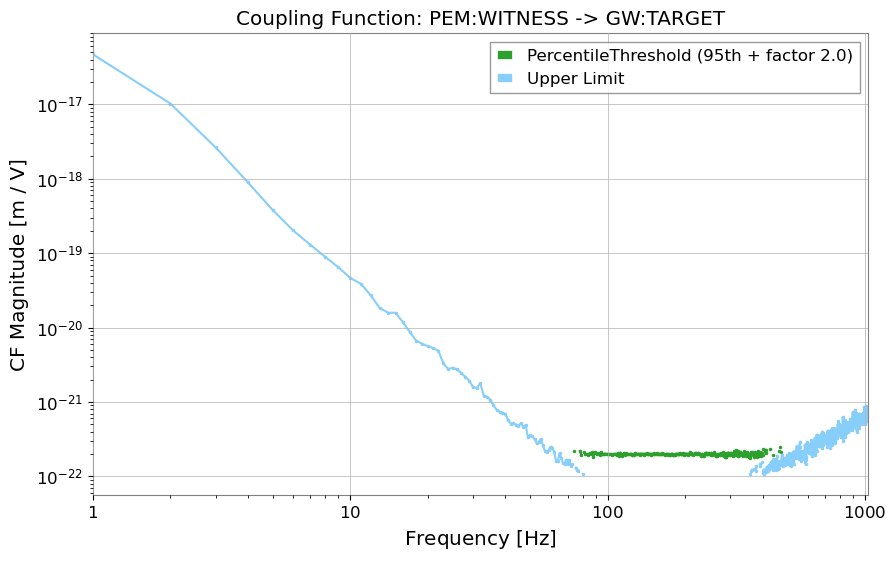

In [6]:
strategy_pct = PercentileThreshold(percentile=95, factor=2.0)

result_pct = estimate_coupling(
    data_inj, data_bkg,
    fftlength=1.0,
    threshold_witness=strategy_pct
)

result_pct.plot_cf(label="PercentileThreshold (95th + factor 2.0)")
plt.legend()

## まとめ

`CouplingFunctionAnalysis` (および `estimate_coupling`) を使用することで、手動で PSD の差分や平方根を計算することなく、直感的にインジェクション解析を行うことができます。
特に、`ThresholdStrategy` を使い分けることで、ノイズ環境に応じた適切な結合推定が可能です。